# NLP - Text Classification of Coronavirus Tweets

Link: https://www.kaggle.com/competitions/sentence-classification-of-coronavirus-tweets

Competition Description

Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

But, it’s not always clear whether a person’s words are actually announcing a disaster.
In this competition, you’re challenged to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. You’ll have access to a dataset of 10,000 tweets that were hand classified. If this is your first time working on an NLP problem, we've created a quick tutorial to get you up and running.

Disclaimer: The dataset for this competition contains text that may be considered profane, vulgar, or offensive.

In [1]:
!pip install -q transformers
!pip install -Uq scikit-learn

In [2]:
import re
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

import torch
from torch.nn import  ConstantPad1d
from torch.nn.functional import pad
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler,random_split, Dataset
from transformers import BertForSequenceClassification, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings(action="ignore")

pd.set_option('display.max_colwidth', 5000)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 2000)

device = torch.device('cuda' if torch.cuda.is_available() else '')

In [3]:
def text_preprocessing(row):
    text = row["text"] + " #" + row["keyword"] if row["keyword"] else row["text"]
    text = re.sub("@\S+", "@user", text)
    text = re.sub("https?://\S+", "<url>" , text)
    text = re.sub("\?+", "?" , text)
    text = re.sub("\.", "." , text)
    text = re.sub("!+", "!" , text)
    text = re.sub("[:;][\)\(pPD]", "!" , text)

    return text
    

In [4]:
#from google.colab import drive
#drive.mount('/content/drive')
#df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/train.csv")

labels_mapping = {0: "false diseaster", 1: "real diseaster"}

df = pd.read_csv("data/train.csv")
df["keyword"].value_counts().tail(50)
df.fillna("", inplace=True)
df["text"] = df.apply(lambda row: text_preprocessing(row), axis=1)
df["label"] = df["target"].map(labels_mapping)
df.head(10)

,id,keyword,location,text,target,label
0,1,,,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,real diseaster
1,4,,,Forest fire near La Ronge Sask. Canada,1,real diseaster
2,5,,,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1,real diseaster
3,6,,,"13,000 people receive #wildfires evacuation orders in California",1,real diseaster
4,7,,,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,real diseaster
5,8,,,#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires,1,real diseaster
6,10,,,"#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas",1,real diseaster
7,13,,,I'm on top of the hill and I can see a fire in the woods...,1,real diseaster
8,14,,,There's an emergency evacuation happening now in the building across the street,1,real diseaster
9,15,,,I'm afraid that the tornado is coming to our area...,1,real diseaster


# Model & Tokenizer

In [6]:
model_name_or_path = 'bert-base-uncased'
model = BertForSequenceClassification.from_pretrained(model_name_or_path,
                                                           num_labels = 2,
                                                           output_attentions = False,
                                                           output_hidden_states = False)
tokenizer = BertTokenizer.from_pretrained(model_name_or_path, do_lower_case=True)
tokenizer.special_tokens_map

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'unk_token': '[UNK]',
 'sep_token': '[SEP]',
 'pad_token': '[PAD]',
 'cls_token': '[CLS]',
 'mask_token': '[MASK]'}

# Dataset

In [7]:
class CustomDataset(torch.utils.data.Dataset):

    def __init__(self, df, tokenizer):
        super().__init__()
        self.tokenizer = tokenizer
        self.inputs = df["text"].values
        self.labels = torch.tensor(df["target"].values).to(torch.int64)

    def __getitem__(self, idx):
        encoded_dict = tokenizer(self.inputs[idx],
                                 add_special_tokens = True,
                                 return_attention_mask = True,
                                 return_tensors = 'pt',
                   )
        return encoded_dict['input_ids'][0], encoded_dict['token_type_ids'][0], encoded_dict['attention_mask'][0], self.labels[idx]

    def __len__(self):
        return len(self.labels)

In [8]:
dataset = CustomDataset(df, tokenizer)
train_size = int(0.8 * len(dataset))
validation_size = len(dataset)  - train_size
train_dataset, validation_dataset = random_split(dataset, [train_size, validation_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(validation_size))


6,090 training samples
1,523 validation samples


# Dataloaders

In [9]:
def padding_function(x, max_len):
    return ConstantPad1d((0, max_len - len(x)), 0)(x)

def collate_fn(batch):
    max_len = max([len(sample[0]) for sample in batch])
    ids = torch.stack([padding_function(sample[0], max_len) for sample in batch])
    token_types = torch.stack([padding_function(sample[1], max_len) for sample in batch])
    attention_masks = torch.stack([padding_function(sample[2], max_len) for sample in batch])
    labels = torch.tensor([sample[3] for sample in batch])
    return ids.to(device), token_types.to(device), attention_masks.to(device), labels.to(device)


In [10]:
batch_size = 4

train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size,
            collate_fn=collate_fn
        )

validation_dataloader = DataLoader(
            validation_dataset,
            sampler = SequentialSampler(validation_dataset),
            batch_size = batch_size,
            collate_fn=collate_fn
        )

In [11]:
epochs = 2
lr =  1e-5
eps = 1e-8

optimizer = AdamW(model.parameters(), lr = lr,  eps =eps)

In [15]:
avg_train_accuracy = []
avg_train_loss = []
avg_val_loss = []
avg_val_accuracy = []

for epoch_i in range(0, epochs):

    running_train_loss = 0
    running_train_accuracy = 0
    running_val_loss = 0
    running_val_accuracy = 0

    model.train()

    loop = tqdm(train_dataloader)

    for batch in loop:

        optimizer.zero_grad()

        output = model(input_ids=batch[0],
                       token_type_ids=batch[1],
                       attention_mask=batch[2],
                       labels=batch[3])

        label_ids = batch[3].to('cpu').numpy()
        predictions = torch.argmax(output.logits.detach().cpu(), 1).numpy()
        running_train_accuracy += (label_ids==predictions).sum()

        loss = output.loss
        running_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        loop.set_description(f"Training. Epoch [{epoch_i}/{epochs}]")
        loop.set_postfix(loss=loss.item(), acc=(label_ids==predictions).sum()/len(predictions))

    avg_train_accuracy.append(running_train_accuracy / train_size)
    avg_train_loss.append(running_train_loss / train_size)

    model.eval()

    with torch.no_grad():
        loop = tqdm(validation_dataloader)
        for batch in loop:

            output = model(input_ids=batch[0],
                          token_type_ids=batch[1],
                          attention_mask=batch[2],
                          labels=batch[3])

            label_ids = batch[3].to('cpu').numpy()
            predictions = torch.argmax(output.logits.detach().cpu(), 1).numpy()
            running_val_accuracy += (label_ids==predictions).sum()

            loss = output.loss
            running_val_loss += loss.item()

            loop.set_description(f"Validation. Epoch [{epoch_i}/{epochs}]")
            loop.set_postfix(loss=loss.item(), acc=(label_ids==predictions).sum()/len(predictions))

    avg_val_accuracy.append(running_val_accuracy / validation_size)
    avg_val_loss.append(running_val_loss / validation_size)

  0%|          | 0/1523 [00:00<?, ?it/s]

  0%|          | 0/381 [00:00<?, ?it/s]

# Resluts

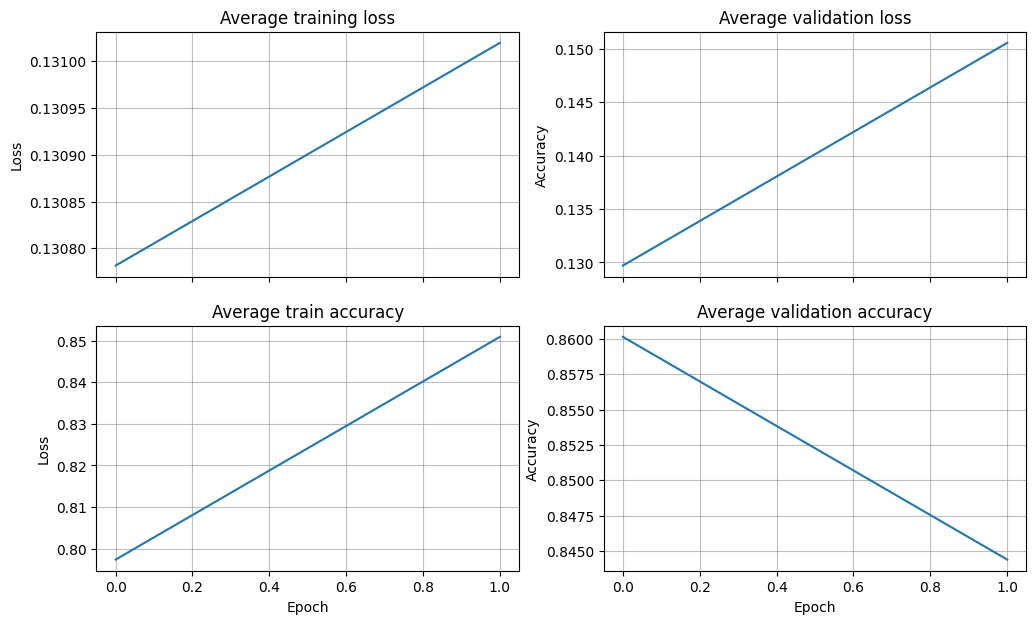

In [17]:
fig, axs = plt.subplots(2,2, figsize=(12, 7), sharex=True, sharey=False)

axs[0][0].plot(avg_train_loss)
axs[0][0].set_title("Average training loss")

axs[0][1].plot(avg_val_loss)
axs[0][1].set_title("Average validation loss")

axs[1][0].plot(avg_train_accuracy)
axs[1][0].set_title("Average train accuracy")

axs[1][1].plot(avg_val_accuracy)
axs[1][1].set_title("Average validation accuracy")

axs[1][0].set_xlabel("Epoch")
axs[1][1].set_xlabel("Epoch")
axs[1][0].set_ylabel("Accuracy")
axs[0][0].set_ylabel("Loss")
axs[1][1].set_ylabel("Accuracy")
axs[0][1].set_ylabel("Loss")

for row in axs:
    row[0].set_ylabel("Loss")
    row[1].set_ylabel("Accuracy")
    #row[1].set_ylim(0.4, 1.01)
    for ax in row:
        ax.grid(c='gray', alpha=0.5)
        

# Evaluate

In [18]:
def evaluate(dataloader):

    true_labels = []
    predicted_labels = []
    language = []

    for i, batch in enumerate(dataloader):

        output = model(input_ids=batch[0],
                          token_type_ids=batch[1],
                          attention_mask=batch[2],
                          labels=batch[3])
        true_labels.append(batch[3].to('cpu').numpy())

        predicted_labels.append(torch.argmax(output.logits.detach().cpu(), 1).numpy())

    true_labels = np.concatenate(true_labels, axis=0)
    predicted_labels = np.concatenate(predicted_labels, axis=0)

    accuracy = sum(true_labels==predicted_labels)/len(true_labels)
    print("accuracy", accuracy)

    cm = confusion_matrix(true_labels, predicted_labels, labels=[0,1], normalize='true')
    ax= plt.subplot()
    sns.heatmap(np.round(cm, 2), annot=True, fmt='g', ax=ax, cmap='cool')
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(["false diseaster", "true diseaster"])
    ax.yaxis.set_ticklabels(["false diseaster", "true diseaster"])
    plt.show()



accuracy 0.8898193760262726


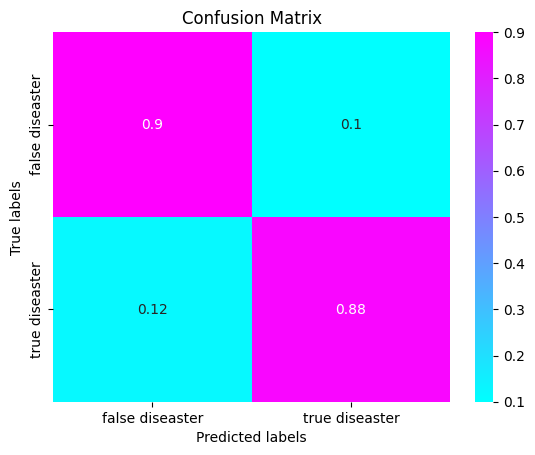

In [19]:
evaluate(train_dataloader)

accuracy 0.8443860801050558


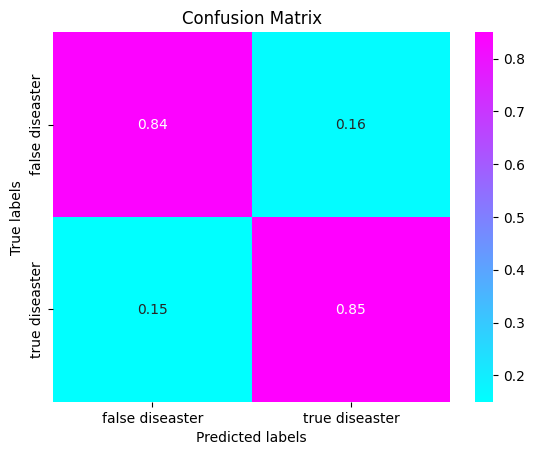

In [20]:
evaluate(validation_dataloader)

# Save pretrained model

In [21]:
model.save_pretrained("classification_model")
tokenizer.save_pretrained("tokenizer")

('tokenizer/tokenizer_config.json',
 'tokenizer/special_tokens_map.json',
 'tokenizer/vocab.txt',
 'tokenizer/added_tokens.json')

# Predict